# NEURAL NETWORK COLLABORATIVE FILTERING
This notebook demonstrates our approach for NNCF on a small sample dataset.  
Note that some of the functionality is implemented in other classes:
* `twitter_preproc.py` (preprocessing)
* `nnpreprocessor.py` (one hot encoding)
* `NNCFNet.py` (the neural network class)

Our neural network approach for the full dataset is in `nncf-submit.py`. To reproduce our submission attempts use: `spark-submit nncf-submit.py`. (NOTE: As described in our report, this script never actually ran through, due to memory overload exceptions. It is just here for reproduction purposes)

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import importlib

# Building Spark Context
# conf = SparkConf().setAll([('spark.executor.memory', '32g'), ('spark.executor.instances','8'),('spark.executor.cores', '12'), ('spark.driver.memory','64g'), ('spark.driver.memoryOverhead', '64g')])
conf = SparkConf()
spark = SparkSession.builder.appName("nncf_train").config(conf=conf).getOrCreate()
sc = spark.sparkContext

## Get training data

In [5]:
import twitter_preproc

base = "///tmp/"
one_k = "traintweet_1000.tsv"
ensemble_train = 'supersecret_ensembletrain5k_bootstrap.tsv'
ensemble_test = 'supersecret_test5k_bootstrap.tsv'
choice = ensemble_train

preproc = twitter_preproc.twitter_preproc(spark, sc, base+choice, MF=True)
traindata = preproc.getDF()

## NNCF specific preprocessing (essentially onehot-encoding)

In [96]:
import nnpreprocessor
importlib.reload(nnpreprocessor)

nnp = nnpreprocessor.NNPreprocessor()
engagement = 'like'
tweets, users, target = nnp.nn_preprocess(traindata)

## Train the NN

epoch  1
epoch  2


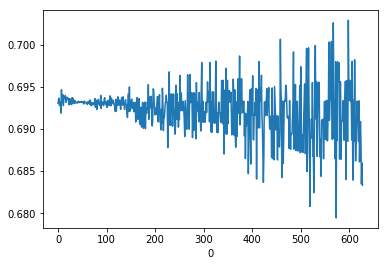

In [103]:
from NNCFNet import Net
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd


# Initalize Hyperparameters
k = 32
n_epochs = 2
batch_size = 16
learning_rate = 0.001

# Initialize Neural Network
net = Net(users.shape[1], tweets.shape[1], k)
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
output = net(users, tweets)

# printing aids
print_c = 0
loss_list = []

# Start training
for epoch in range(n_epochs):
    
    print("epoch ", epoch+1)

    permutation = torch.randperm(users.size()[0])
    for i in range(0,users.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x_user = users[indices]
        batch_x_tweet = tweets[indices]
        batch_y = target[indices]

        outputs = net.forward(batch_x_user, batch_x_tweet)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        # print & track loss
        loss_list.append((print_c,float(loss)))
        print_c += 1
        

plot_df = pd.DataFrame(loss_list)
ax = plot_df.set_index(0)[1].plot();

In [98]:
# save loss plot
fig = ax.get_figure()
fig.savefig('../misc/' + engagement + '.' + 'k' + str(k) + 'ep' + str(n_epochs) + 'batch' + str(batch_size) + str('lr') + str(learning_rate) + '_sgd&bce.png')

## Create & format output

In [11]:
from pyspark.sql.functions import monotonically_increasing_id
import numpy as np

# get predictions
net.eval()
prediction = net(users, tweets)
p_vec = prediction.detach().numpy().flatten()
scaled = (p_vec - np.min(p_vec))/np.ptp(p_vec)
probabilities = [float(x) for x in scaled]

# get original order
order_df = traindata.withColumn("original_order", monotonically_increasing_id())
order_df = order_df.select("engaging_user_id", "tweet_id", 'original_order')
sorting_tweets = nnp.get_id_indices(order_df, id_column='tweet_id')

# rejoin labels
result = order_df.join(sorting_tweets, 'tweet_id').sort('original_order').rdd.map(lambda x: (x['engaging_user_id'], x['tweet_id'], probabilities[x['tweet_id_index']]))

In [12]:
result.toDF(["engaging_user_id", "tweet_id", 'target']).take(10)

[Row(engaging_user_id='7B7D097D72AF9DCD7E837DFF78CEDF52', tweet_id='5AFF129F735EC6F0253F737AE3F2F42F', target=0.6835331916809082),
 Row(engaging_user_id='A642139C310DB3F102228A5DBA18B6E0', tweet_id='FD74F0E085CB3E023979AE780EA8FC80', target=0.592300534248352),
 Row(engaging_user_id='ED9DEBA062966F6C8205E73C0E649173', tweet_id='DFCCD8ADEFA7470ECA7A951F458596FA', target=0.3181644082069397),
 Row(engaging_user_id='6676161018E87D26FF70851FA9B0A392', tweet_id='21E6E7126A127CA8E0169D77F9AFF6A6', target=0.5780625343322754),
 Row(engaging_user_id='782C21B4DE30F3778FC4831AE66364E7', tweet_id='B0CE7999915ACA4460C643FCB3DC71AC', target=0.6954712271690369),
 Row(engaging_user_id='91EE3A7B13352EBB028F53DADD6D68FF', tweet_id='6A7F4301D0F4E5E9362CD0B1DFA7804A', target=0.48337987065315247),
 Row(engaging_user_id='488D313AB8BDB52E0A9D368C5E6CFCA1', tweet_id='B0900E5B6D77E782077DF1BD3DCE5A7B', target=0.40419474244117737),
 Row(engaging_user_id='71C35F95D19CBE2F245C3F01723013EB', tweet_id='DE79883E7D9BDF